# 2.14-2.20- Objective 1 Metro of Amsterdam

In [8]:
import geopandas
import pandas
from osgeo import ogr,gdal
import os
import numpy 
from tqdm import tqdm
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt

gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 


def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}

def landuse(osm_path):
    """
    Function to extract land-use polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.    
    """    
    return(retrieve(osm_path,'multipolygons',['landuse']))

def buildings(osm_path):
    """
    Function to extract building polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique building polygons.    
    """
    return retrieve(osm_path, 'multipolygons',['building','amenity'])

def roads(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """   
    return retrieve(osm_path,'lines',['highway']) 
 
#def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    #return retrieve(osm_path,'lines',['railway','service'],**{"service":[" IS NOT NULL"]})

def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def train_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['man_made'],**{'man_made':["='communications_tower'"]})).rename(columns={'man_made': 'asset'})

def subway_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway'],**{'railway':["='subway_entrance'"]}))

def tram_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway'],**{'railway':["='tram_stop'"]}))

def ferries(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """
    return retrieve(osm_path,'lines',['route'],**{"route":["='ferry'",]})

def electricity(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.   
    """    
    return retrieve(osm_path,'lines',['power','voltage']) #,**{'voltage':[" IS NULL"],}

def mainRoads(osm_path):
    """
    Function to extract main road linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique main road linestrings.   
    """ 
    return retrieve(osm_path,'lines',['highway','oneway','lanes','maxspeed'],**{'highway':["='primary' or ","='trunk' or ","='motorway' or ","='trunk_link' or ",
                    "='primary_link' or ", "='secondary' or ","='tertiary' or ","='tertiary_link'"]})


def remove_overlap_openstreetmap(gdf):
    """
    Function to remove overlap in polygons in from OpenStreetMap.
    
    Arguments:
        *gdf* : a geopandas GeoDataFrame with all unique railway linestrings.
        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with (almost) non-overlapping polygons.
    
    """
    
    gdf['sq_area'] = gdf.area

    new_landuse = []
    for use in tqdm(gdf.itertuples(index=False),total=len(gdf),desc='Get unique shapes'):
        use_geom = use.geometry
        matches = gdf.loc[list(gdf.sindex.intersection(use.geometry.bounds))]
        for match in matches.itertuples(index=False):
            if use.sq_area > match.sq_area:
                use_geom = use_geom.difference(match.geometry)
        new_landuse.append([use.osm_id,use.landuse,use_geom])

    new_gdf  =  geopandas.GeoDataFrame(pandas.DataFrame(new_landuse,columns=['osm_id','landuse','geometry'])) 
    new_gdf.crs = {'init' : 'epsg:4326'}
    return new_gdf


def extract_value_other_gdf(x,gdf,col_name):
    """
    Function to extract value from column from other GeoDataFrame
    
    Arguments:
        *x* : row of main GeoDataFrame.
        
        *gdf* : geopandas GeoDataFrame from which we want to extract values.
        
        *col_name* : the column name from which we want to get the value.
        
    
    """
    try:
        return gdf.loc[list(gdf.sindex.intersection(x.geometry.bounds))][col_name].values[0]
    except:
        return None

def get_losses(x,damage_curves,damage_values):
    """
    Function to estimate the damages.
    
    Arguments:
        *x* : row of main GeoDataFrame
        
        *damage_curves*: pandas DataFrame of curves. Inundation depths should be the index.
        
        *damage_values*: dictionary with maximum damage values.
        
    Returns:
        
        Total damage for the given land-use object.
    
    """
    
    return numpy.interp(x.depth,list(damage_curves.index),list(damage_curves[x.landuse]))*damage_values[x.landuse]*x.area_m2

In [9]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [10]:
train_stations(osm_data)

,osm_id,railway,geometry
0,46199966,station,POINT (4.95606 52.33026)
1,250222266,station,POINT (4.85758 52.33840)
2,250224485,station,POINT (4.83529 52.37266)
3,250233810,station,POINT (4.96017 52.29799)
4,289445435,station,POINT (4.93052 52.32945)
5,427565080,station,POINT (4.91763 52.33173)
6,1633149045,station,POINT (4.74687 52.38598)
7,2237721918,station,POINT (4.83822 52.37961)
8,3938547498,station,POINT (4.83811 52.38903)
9,4005961975,station,POINT (4.94709 52.31224)


<AxesSubplot: >

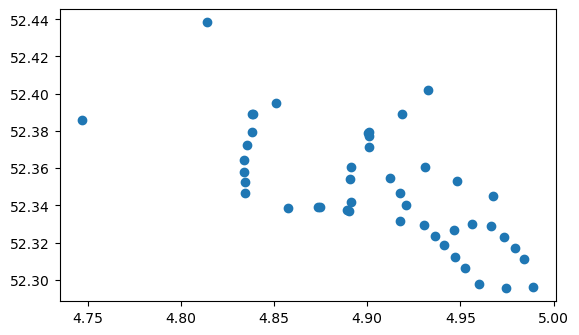

In [11]:
df_trainsta = train_stations(osm_data)
df_trainsta.plot()

In [12]:
subway_stations(osm_data)

,osm_id,railway,geometry
0,60868600,subway_entrance,POINT (4.90215 52.36784)
1,60893869,subway_entrance,POINT (4.90492 52.36622)
2,154721379,subway_entrance,POINT (4.90034 52.37053)
3,237812186,subway_entrance,POINT (4.91253 52.35313)
4,240489053,subway_entrance,POINT (4.91312 52.35325)
5,240489054,subway_entrance,POINT (4.91176 52.35549)
6,240489058,subway_entrance,POINT (4.90806 52.36159)
7,240489059,subway_entrance,POINT (4.90854 52.36092)
8,289473109,subway_entrance,POINT (4.91124 52.35530)
9,315065746,subway_entrance,POINT (4.92071 52.33989)


<AxesSubplot: >

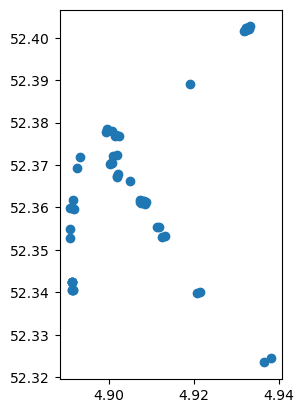

In [13]:
df_substa = subway_stations(osm_data)
df_substa.plot()

In [14]:
tram_stations(osm_data)

,osm_id,railway,geometry
0,46326414,tram_stop,POINT (4.85218 52.35805)
1,46350382,tram_stop,POINT (4.91936 52.36350)
2,46369643,tram_stop,POINT (4.90536 52.36796)
3,46432024,tram_stop,POINT (4.87920 52.38131)
4,46462976,tram_stop,POINT (4.88514 52.38808)
...,...,...,...
459,9982135037,tram_stop,POINT (4.90097 52.37780)
460,9982135040,tram_stop,POINT (4.90098 52.37775)
461,9982135046,tram_stop,POINT (4.90098 52.37770)
462,10273052985,tram_stop,POINT (4.89064 52.37190)


<AxesSubplot: >

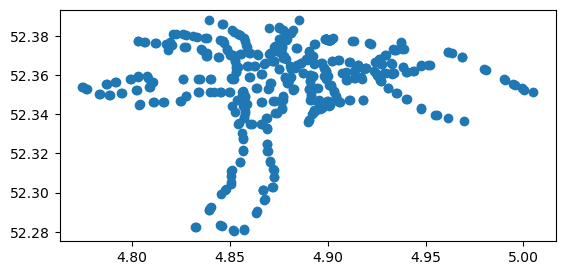

In [15]:
df_tramsta = tram_stations(osm_data)
df_tramsta.plot()

In [16]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
railway(osm_data)

,osm_id,railway,service,geometry
0,4371188,razed,None,"LINESTRING (4.90939 52.38270, 4.90970 52.38292)"
1,4729659,abandoned,None,"LINESTRING (4.85130 52.38613, 4.85074 52.38618..."
2,6302461,rail,spur,"LINESTRING (4.83766 52.40752, 4.83783 52.40753..."
3,6302610,abandoned,spur,"LINESTRING (4.85887 52.39803, 4.85819 52.39834..."
4,6303488,rail,None,"LINESTRING (4.82855 52.33875, 4.82804 52.33875..."
...,...,...,...,...
5635,1131538382,subway,None,"LINESTRING (4.92014 52.34166, 4.92010 52.34174)"
5636,1131538383,subway,None,"LINESTRING (4.92004 52.34172, 4.92008 52.34164)"
5637,1131538384,subway,None,"LINESTRING (4.91972 52.34236, 4.91976 52.34228..."
5638,1131538385,subway,None,"LINESTRING (4.91942 52.34245, 4.91925 52.34280)"


In [21]:
df_railway = railway(osm_data)

<AxesSubplot: >

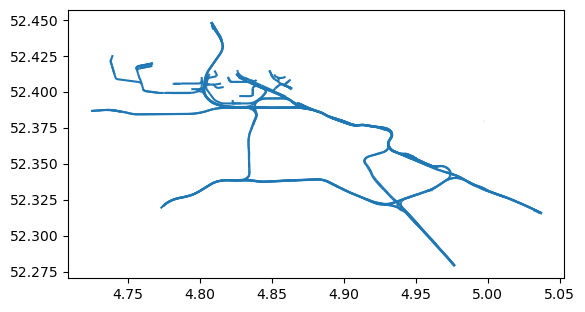

In [18]:
train = df_railway.loc[df_railway.railway == 'rail']
train.plot()

In [22]:
train

,osm_id,railway,service,geometry
2,6302461,rail,spur,"LINESTRING (4.83766 52.40752, 4.83783 52.40753..."
4,6303488,rail,None,"LINESTRING (4.82855 52.33875, 4.82804 52.33875..."
5,6303491,rail,None,"LINESTRING (4.82936 52.33875, 4.82879 52.33876)"
6,6303492,rail,None,"LINESTRING (4.82731 52.33872, 4.82687 52.33870..."
7,6303498,rail,None,"LINESTRING (4.82728 52.33857, 4.82714 52.33857..."
...,...,...,...,...
5624,1123358544,rail,crossover,"LINESTRING (4.91023 52.37690, 4.91024 52.37691)"
5626,1131538373,rail,None,"LINESTRING (4.91972 52.34165, 4.91976 52.34157)"
5627,1131538374,rail,None,"LINESTRING (4.91936 52.34243, 4.91938 52.34238..."
5632,1131538379,rail,None,"LINESTRING (4.92016 52.34175, 4.91975 52.34241..."


<AxesSubplot: >

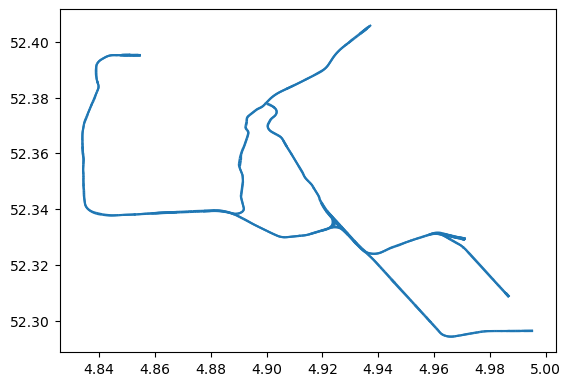

In [19]:
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

<AxesSubplot: >

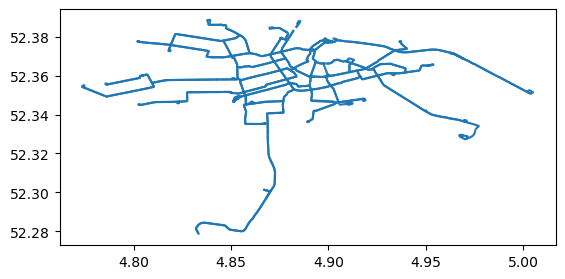

In [20]:
tram = df_railway.loc[df_railway.railway == 'tram']
tram.plot()

In [ ]:
import openpyxl
df_railway.to_excel('./test.xlsx',header=True, index=False,sheet_name='mydata')

In [ ]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
roads(osm_data)

In [ ]:
df_road = roads(osm_data)
df_road.plot()

In [ ]:
 pip install openpyxl